# 1. RNN的实现(不用框架)

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 定义批量大小和时间步数
batch_size, num_steps = 32, 35
# 加载时间机器数据并创建词汇表
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
# 独热编码
# 打印词汇表的大小
print(len(vocab))
# 使用独热编码将 [0, 2] 表示的物体下标转换为独热向量，其中0表示第一个元素，2表示第3个元素
F.one_hot(torch.tensor([0,2]),len(vocab)) # [0,2] 表示物体下标，0表示第一个元素，2表示第3个元素

28


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [3]:
# 小批量形状是(批量大小，时间步数)
# 创建一个张量，形状为(2, 5)，表示批量大小为2，时间步数为5
X = torch.arange(10).reshape((2,5)) 
# 对X的转置进行独热编码，其中28表示编码长度，返回独热编码后的形状
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [4]:
# 初始化循环神经网络模型的模型参数
def get_params(vocab_size, num_hiddens, device):
    # 设置输入和输出的维度为词汇表大小
    num_inputs = num_outputs = vocab_size
    
    # 定义normal函数用于生成服从正态分布的随机张量，并乘以0.01进行缩放
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    # 初始化模型参数
    # 输入到隐藏层的权重矩阵，形状为(词汇表大小, 隐藏单元个数)
    W_xh = normal((num_inputs, num_hiddens))
    # 隐藏层到隐藏层的权重矩阵，形状为(隐藏单元个数, 隐藏单元个数)
    W_hh = normal((num_hiddens, num_hiddens))
    # 隐藏层的偏置向量，形状为(隐藏单元个数,)
    b_h = torch.zeros(num_hiddens, device=device)
    # 隐藏层到输出层的权重矩阵，形状为(隐藏单元个数, 词汇表大小)
    W_hq = normal((num_hiddens, num_outputs))
    # 输出层的偏置向量，形状为(词汇表大小,)
    b_q = torch.zeros(num_outputs, device=device)
    # 将所有参数放入列表中
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    # 遍历所有参数
    for param in params:
        # 设置参数的requires_grad为True，用于梯度计算
        param.requires_grad_(True)
    # 返回模型的参数
    return params

In [5]:
# 一个init_rnn_state函数在初始化时返回隐藏状态
def init_rnn_state(batch_size, num_hiddens, device):
    # 返回一个包含隐藏状态的元组，元组中的唯一元素是一个形状为(批量大小, 隐藏单元个数)的全零张量   
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [6]:
# 下面的rnn函数定义了如何在一个时间步计算隐藏状态和输出
def rnn(inputs, state, params):
    # 从参数元组中解包获取输入到隐藏层的权重矩阵 W_xh，
    # 隐藏层到隐藏层的权重矩阵 W_hh，
    # 隐藏层的偏置向量 b_h，
    # 隐藏层到输出层的权重矩阵 W_hq，
    # 输出层的偏置向量 b_q
    W_xh, W_hh, b_h, W_hq, b_q = params
    # 从状态元组中解包获取隐藏状态 H
    # 注意这里使用逗号是为了确保 H 为一个元组
    H, = state
    # 创建一个空列表用于存储输出
    outputs = []
    # 对于输入序列中的每个输入 X
    # 输入序列通常是一个时间步的数据，可以是单个时间步的特征向量或者是嵌入向量
    for X in inputs:
        # 计算新的隐藏状态 H，使用双曲正切函数作为激活函数
        # 根据当前输入 X、上一时间步的隐藏状态 H、以及权重矩阵和偏置向量来计算
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        # 计算输出 Y，通过隐藏状态 H 与权重矩阵 W_hq 相乘并加上偏置向量 b_q 得到
        Y = torch.mm(H, W_hq) + b_q
        # 将输出 Y 添加到输出列表中
        outputs.append(Y)
    # 将输出列表中的输出张量沿着行维度进行拼接，得到一个形状为 (时间步数 * 批量大小, 输出维度) 的张量
    # 返回拼接后的输出张量和最后一个时间步的隐藏状态 H
    return torch.cat(outputs, dim=0), (H,)

In [7]:
# 创建一个类来包装这些函数
class RNNModelScratch:
    # 初始化模型参数
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                init_state, forward_fn):
        # 保存词汇表大小和隐藏单元个数作为类的属性
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        # 调用 get_params 函数初始化模型的参数，并保存为类的属性
        # 参数包括输入到隐藏层的权重矩阵、隐藏层到隐藏层的权重矩阵、隐藏层的偏置向量、隐藏层到输出层的权重矩阵、输出层的偏置向量
        self.params = get_params(vocab_size, num_hiddens, device)
        # 初始化隐藏状态的函数和前向传播函数
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state):
        # 将输入序列 X 进行独热编码，形状为 (时间步数, 批量大小, 词汇表大小)
        # 并将数据类型转换为浮点型
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        # 调用前向传播函数进行模型计算，并返回输出
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        # 返回初始化的隐藏状态，用于模型的初始时间步
        return self.init_state(batch_size, self.num_hiddens, device)

In [8]:
# 检查输出是否具有正确的形状
# 设置隐藏单元个数为 512
num_hiddens = 512
# 创建一个 RNNModelScratch 的实例 net，指定词汇表大小、隐藏单元个数、设备、获取参数函数、初始化隐藏状态函数和前向传播函数
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                     init_rnn_state, rnn)
# 获取模型的初始隐藏状态，输入的批量大小为 X 的行数，设备使用与 X 相同的设备
state = net.begin_state(X.shape[0], d2l.try_gpu())
# 使用输入 X 和初始隐藏状态进行前向传播计算，得到输出张量 Y 和更新后的隐藏状态 new_state
# 将输入和状态都移动到与 X 相同的设备上进行计算
Y, new_state = net(X.to(d2l.try_gpu()),state)
# 输出 Y 的形状，new_state 的长度（即元素个数）和 new_state 中第一个元素的形状
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [9]:
# 首先定义预测函数来生成用户提供的prefix之后的新字符
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在 'prefix' 后面生成新字符。"""
    # 获取模型的初始隐藏状态，批量大小为 1，设备为指定的设备
    state = net.begin_state(batch_size=1, device=device)
    # 将 prefix 的第一个字符索引添加到输出列表中
    outputs = [vocab[prefix[0]]]
    # 定义一个函数 get_input，用于获取输入序列的张量表示
    # 输入序列只包含一个字符，将该字符的索引转换为张量，并进行形状调整为 (1, 1)
    get_input = lambda: torch.tensor([outputs[-1]],device=device).reshape(1,1)  
    # 对于 prefix 中除第一个字符之外的每个字符 y
    for y in prefix[1:]:
        # 使用当前输入字符和隐藏状态进行前向传播计算，得到输出和更新后的隐藏状态
        _, state = net(get_input(), state)
        # 将字符 y 的索引添加到输出列表中
        outputs.append(vocab[y])
    # 生成指定数量的新字符
    for _ in range(num_preds):
        # 使用当前输入字符和隐藏状态进行前向传播计算，得到输出和更新后的隐藏状态
        y, state = net(get_input(), state)
        # 将输出张量中概率最大的字符索引添加到输出列表中
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    # 将输出列表中的字符索引转换为对应的字符，并拼接成一个字符串返回
    return ''.join([vocab.idx_to_token[i] for i in outputs])
# 生成以 'time traveller ' 为前缀的 10 个新字符
# 注意：由于模型尚未训练，这里的预测结果是随机初始化后的预测
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu()) 

'time traveller uupwqaydrq'

① 梯度裁剪$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$

In [10]:
def grad_clipping(net, theta):
    """裁剪梯度。"""
    # 如果 net 是 nn.Module 的实例（即使用 PyTorch 构建的模型）
    if isinstance(net, nn.Module):
        # 获取所有需要计算梯度的参数列表
        params = [p for p in net.parameters() if p.requires_grad]
    # 如果 net 是自定义的模型（例如上述的 RNNModelScratch）
    else:
        # 获取自定义模型的参数列表
        params = net.params
    # 计算参数梯度的范数，即所有参数梯度平方和的平方根
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    # 如果梯度范数超过指定阈值 theta
    if norm > theta:
        # 对于每个参数
        for param in params:
            # 将参数的梯度值裁剪至指定范围内，保持梯度范数不超过 theta
            param.grad[:] *= theta / norm

In [11]:
# 定义一个函数来训练只有一个迭代周期的模型
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期"""
    # 初始化隐藏状态和计时器
    state, timer = None, d2l.Timer()
    # 初始化度量指标的累加器，用于计算损失和样本数量
    metric = d2l.Accumulator(2)
    # 遍历训练迭代器中的每个批次数据
    for X, Y in train_iter:
        # 如果隐藏状态为空或使用随机迭代器
        if state is None or use_random_iter:
            # 初始化隐藏状态，批量大小为 X 的行数，设备为指定的设备
            state = net.begin_state(batch_size=X.shape[0],device=device)
        else:
            # 如果 net 是 nn.Module 的实例且隐藏状态不是元组类型
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # 分离隐藏状态的计算图
                state.detach_()
            else:
                # 对于隐藏状态中的每个元素
                for s in state:
                    # 分离隐藏状态的计算图，用于减少内存占用和加速计算
                    s.detach_()
        # 将目标序列 Y 转置并展平为一维张量
        y = Y.T.reshape(-1)
        # 将输入序列和目标序列移动到指定的设备上
        X, y = X.to(device), y.to(device)
        # 使用输入序列和隐藏状态进行前向传播计算，得到预测值和更新后的隐藏状态
        y_hat, state = net(X, state)
        # 计算预测值与目标值之间的损失
        l = loss(y_hat, y.long()).mean()
        # 如果使用 PyTorch 内置的优化器
        if isinstance(updater, torch.optim.Optimizer):
            # 清空优化器中的梯度
            updater.zero_grad()
            # 反向传播计算梯度
            l.backward()
            # 裁剪梯度
            grad_clipping(net,1)
            # 执行一步参数更新
            updater.step()
        else:
            # 反向传播计算梯度
            l.backward()
            # 裁剪梯度
            grad_clipping(net,1)
            # 执行自定义的参数更新函数
            updater(batch_size=1)
        # 累加损失和样本数量
        metric.add(l * y.numel(), y.numel())
    # 计算平均损失和每秒处理的样本数，返回平均损失的指数形式（以 e 为底）和每秒样本处理速度
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

In [12]:
# 训练函数支持从零开始或使用高级API实现的循环神经网络模型
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型"""
    # 定义损失函数为交叉熵损失
    loss = nn.CrossEntropyLoss()
    # 创建动画对象，用于可视化训练过程的损失变化
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'],xlim=[10,num_epochs])    
    # 如果模型是 nn.Module 的实例
    if isinstance(net, nn.Module):
        # 使用 PyTorch 的优化器 SGD 进行参数更新
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        # # 否则，使用自定义的梯度下降函数进行参数更新
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 定义一个预测函数，用于生成给定前缀之后的新字符序列
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 遍历每个迭代周期
    for epoch in range(num_epochs):
        # 训练一个迭代周期，并返回困惑度和每秒样本处理速度
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)   
        # 每隔 10 个迭代周期生成
        if (epoch + 1) % 10 == 0:
            # 打印以 'time traveller' 为前缀的新字符序列
            print(predict('time traveller'))
            # 将当前迭代周期的困惑度添加到动画中进行可视化
            animator.add(epoch + 1, [ppl])
    # 打印最终的困惑度和每秒样本处理速度
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 标记/秒 {str(device)}')
    # 生成并打印以 'time traveller' 为前缀的新字符序列
    print(predict('time traveller'))
    # 生成并打印以 'traveller' 为前缀的新字符序列
    print(predict('traveller'))

困惑度 1.0, 74455.3 标记/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


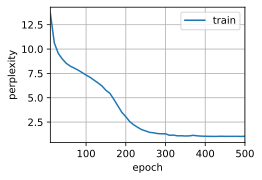

In [13]:
# 现在我们可以训练循环神经网络模型
# 设置迭代周期数和学习率
num_epochs, lr = 500, 1
# 调用训练函数进行模型训练，使用训练数据迭代器、词汇表、学习率、迭代周期数和设备信息作为输入
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.3, 69106.4 标记/秒 cuda:0
time travellerit s against reason said filbywhat thatlly i so di
travellerit s against reason said filbywhat thatlly i so di


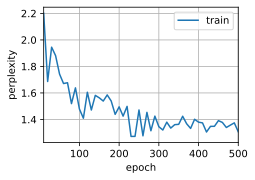

In [14]:
# 最后，让我们检查一下使用随即抽样方法的结果
# 调用训练函数进行模型训练，使用训练数据迭代器、词汇表、学习率、迭代周期数、设备信息和随机抽样标志位作为输入
# 设置 use_random_iter 参数为 True，表示使用随机抽样方法进行训练
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True) 

# 2. RNN的实现(用框架)

In [15]:
# 导入 PyTorch 库
import torch
# 导入 nn 模块，用于定义神经网络模型的基类
from torch import nn
# 导入 functional 模块，用于定义神经网络模型中的激活函数等功能
from torch.nn import functional as F
# 导入 d2l.torch 模块，包含了与深度学习相关的工具函数和类
from d2l import torch as d2l

# 设置批量大小和时间步数
batch_size, num_steps = 32, 35
# 调用 load_data_time_machine 函数加载时间机器数据集，返回训练数据迭代器和词汇表
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [16]:
# 定义模型
# 设置隐藏单元的数量为 256
num_hiddens = 256
# 使用 nn.RNN 类定义一个循环神经网络层
# 输入大小为词汇表的大小，隐藏单元数量为 num_hiddens
# 将该循环神经网络层赋值给 rnn_layer
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [17]:
# 使用张量来初始化隐藏状态
# 创建一个形状为 (1, batch_size, num_hiddens) 的张量，用于初始化隐藏状态
# 全部元素初始化为 0
# 将该张量赋值给变量 state
state = torch.zeros((1, batch_size, num_hiddens))
# 打印隐藏状态张量的形状
state.shape

torch.Size([1, 32, 256])

In [18]:
# 通过一个隐藏状态和一个输入，我们可以用更新后的隐藏状态计算输出
# 创建一个形状为 (num_steps, batch_size, len(vocab)) 的随机张量 X
# 用于表示输入的序列，每个时间步的输入为一个词汇表大小的独热编码向量
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
# 将输入 X 和初始隐藏状态 state 作为输入传递给循环神经网络层 rnn_layer 进行前向计算
# 返回输出张量 Y 和更新后的隐藏状态 state_new
Y, state_new = rnn_layer(X, state)
# 打印输出张量 Y 和更新后的隐藏状态 state_new 的形状
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [19]:
# 我们为一个完整的循环神经网络模型定义一个RNNModel类
class RNNModel(nn.Module):
    """循环神经网络模型"""
    # 初始化函数
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        # 调用父类的构造函数，初始化继承的属性
        super(RNNModel, self).__init__(**kwargs)
        # 循环神经网络层
        self.rnn = rnn_layer
        # 词汇表大小
        self.vocab_size = vocab_size
        # 隐藏状态的大小
        self.num_hiddens = self.rnn.hidden_size
        # 如果循环神经网络不是双向的
        if not self.rnn.bidirectional:
            # 方向数量为1
            self.num_directions = 1
            # 线性层的输入大小为隐藏状态大小，输出大小为词汇表大小
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        # 如果循环神经网络是双向的
        else:
            # 方向数量为2
            self.num_directions = 2
            # 线性层的输入大小为隐藏状态大小的两倍，输出大小为词汇表大小
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)  
            
    # 前项传播函数
    def forward(self, inputs, state):
        # 将输入的索引序列转换为独热编码张量 X
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        # 将 X 转换为 float32 类型
        X = X.to(torch.float32)
        # 使用循环神经网络层 rnn 进行前向计算，返回输出张量 Y 和更新后的隐藏状态 state
        Y, state = self.rnn(X, state)
        # 将输出张量 Y 展平并通过线性层 linear 进行变换得到最终的输出
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        # 返回最终输出和更新后的隐藏状态
        return output, state

    # 创建循环神经网络的初始隐藏状态
    def begin_state(self, device, batch_size=1):
        # 如果循环神经网络不是LSTM类型
        if not isinstance(self.rnn, nn.LSTM):
            # 创建全零的隐藏状态张量
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens),
                               device=device)
        # 如果循环神经网络是LSTM类型
        else:
            # 创建全零的隐藏状态张量和记忆单元张量
            # 第一个张量是全零的隐藏状态张量，第二个张量是全零的记忆单元张量
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device), 
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens), 
                                device=device))

In [20]:
# 用一个具有随即权重的模型进行预测
# 尝试使用GPU设备，如果不可用则使用CPU
device = d2l.try_gpu()
# 创建RNN模型实例
net = RNNModel(rnn_layer, vocab_size=len(vocab))
# 将模型移动到指定设备上
net = net.to(device)
# 对模型进行预测，生成文本
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerrrrrrrrrrr'

perplexity 1.3, 270684.1 tokens/sec on cuda:0
time travelleryon oug heally a chifily exper and have at atw yo 
travelleryon o have e tern whis vewy cand scascolleredit to


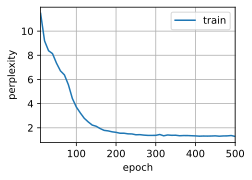

In [21]:
# 使用高级API训练模型
# 设置训练的迭代周期数和学习率
num_epochs, lr = 500, 1
# 使用高级API训练模型，传入模型、训练数据迭代器、词汇表、学习率和迭代周期数进行训练
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)